In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 
%matplotlib inline

# 데이터확인

In [2]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')
df.head(5)

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

In [3]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 1366.83it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

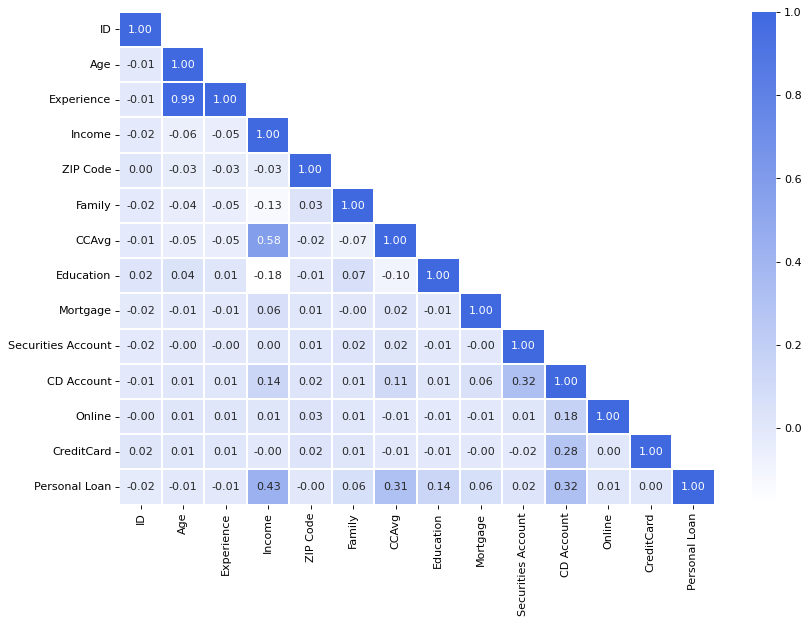

In [5]:
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

target = 'Personal Loan'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

# 이상치 제거

In [6]:
df[df['Experience']<0]['Experience'].count()

52

In [7]:
df[df['Experience']<0]['Experience'].value_counts()

Experience
-1    33
-2    15
-3     4
Name: count, dtype: int64

In [8]:
df['Experience'] = df['Experience'].apply(abs)

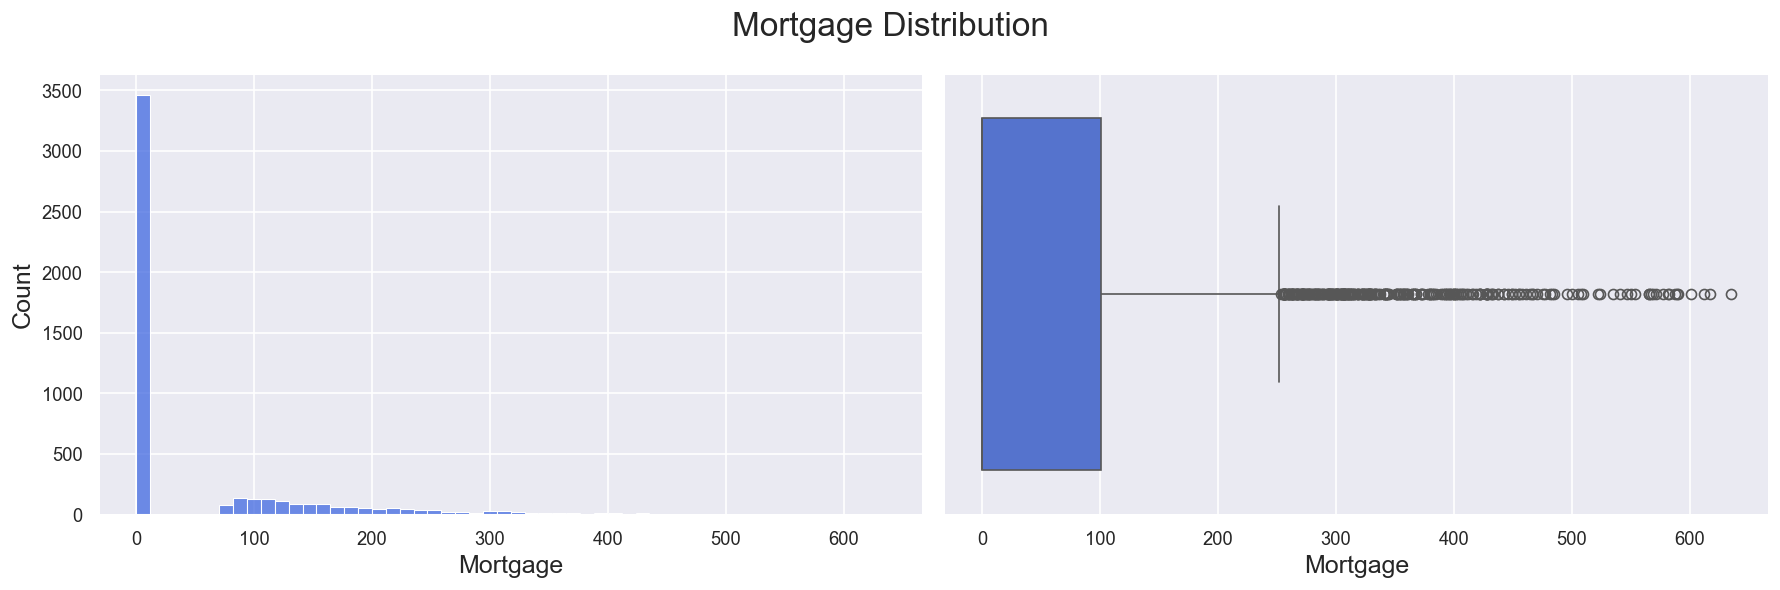

In [9]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Mortgage', data=df, color='royalblue', ax=ax[0])
sns.boxplot(x='Mortgage', data=df, color='royalblue', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

105

In [11]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

# 특성 스케일링

In [12]:
df['CCAvg'] = df['CCAvg']*12

In [13]:
df[df['ZIP Code']<20000]

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  \
375  385   51          25      21      9307       4    7.2          3   

     Mortgage  Personal Loan  Securities Account  CD Account  Online  \
375         0              0                   0           0       1   

     CreditCard  
375           1

In [14]:
df.drop(df[df['ZIP Code']<20000].index, inplace=True)
df.reset_index(drop=True, inplace =True)

In [15]:
df.drop('ID', axis=1, inplace=True) 

# Categorical Features vs Target

In [16]:
# 데이터셋에서 중요한 범주형 특징의 이름을 포함하는 리스트 정의
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# target name
Target = 'Personal Loan'

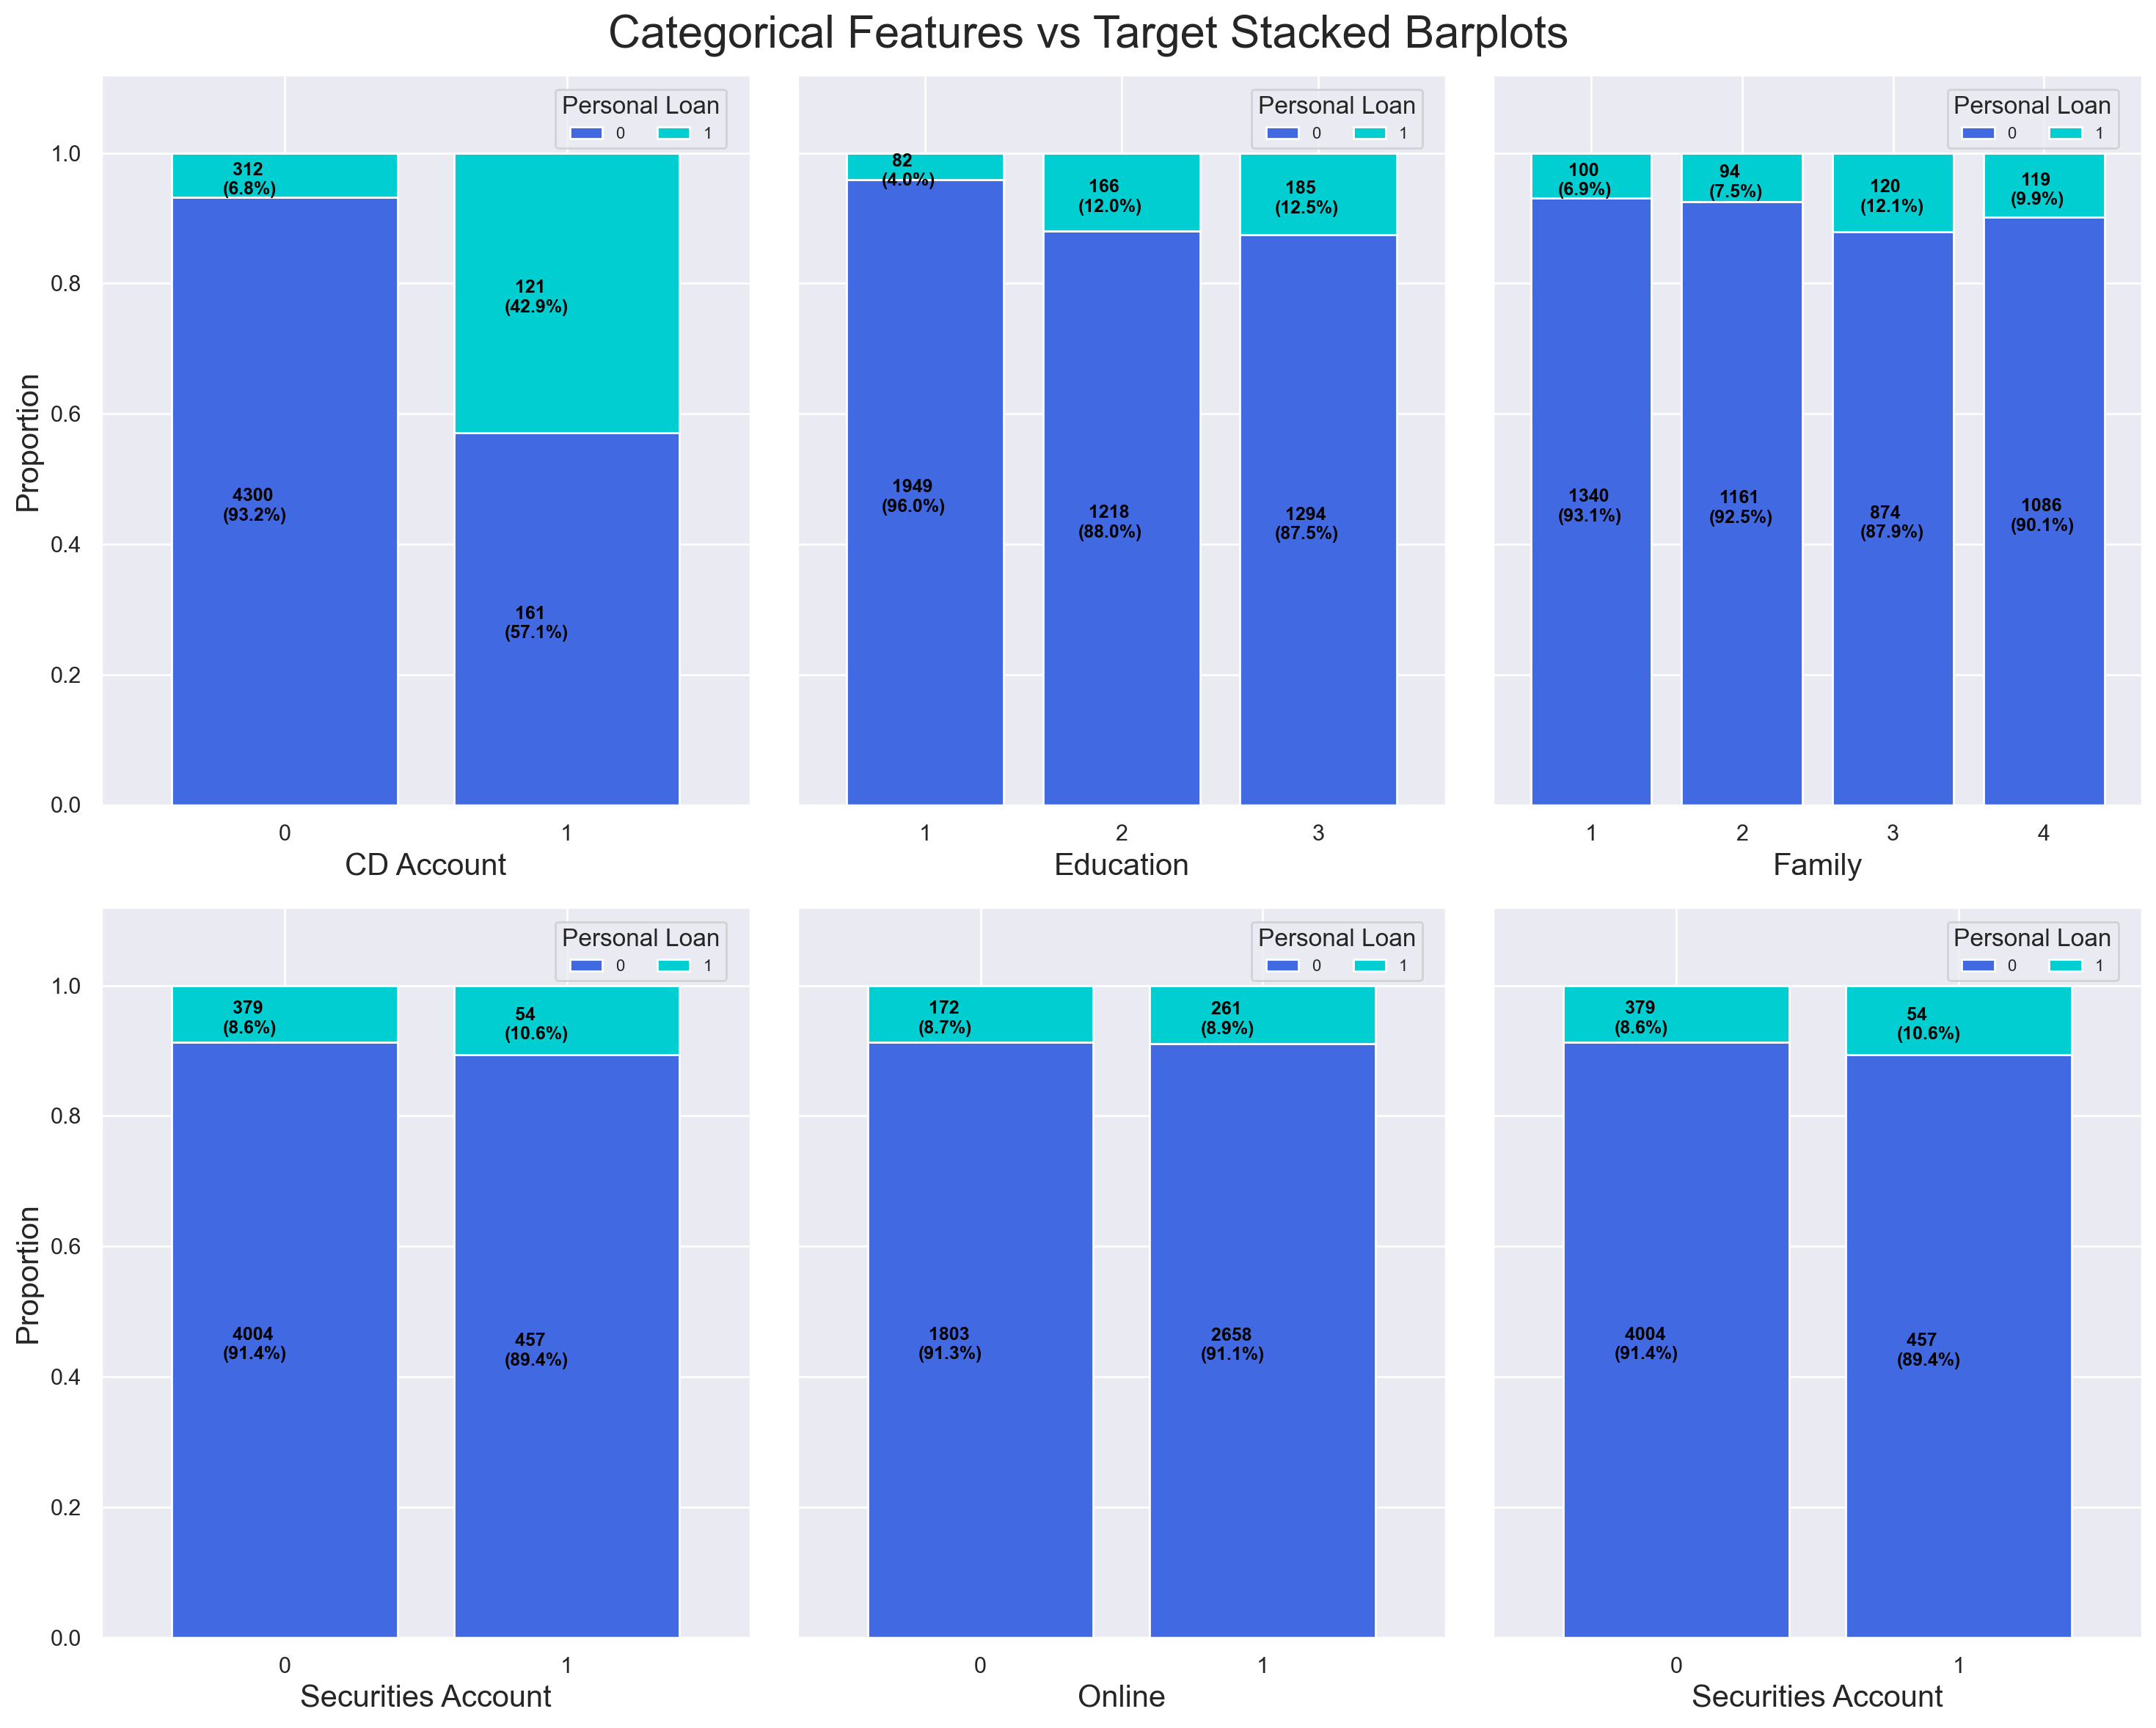

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):
    
    # 각 특성의 범주별로 대출 구매 여부의 비율을 나타내는 표
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    cmp = ListedColormap(['royalblue', 'darkturquoise'])
    
    # Plot
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # 그래프의 개별 막대에 비율과 개수 추가
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # legend
    ax[x,y].legend(title='Personal Loan', loc=(0.7,0.9), fontsize=8, ncol=2)
    # y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
            

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

In [18]:
# 데이터셋에서 중요한 수치형 특징의 이름을 포함하는 리스트 정의 
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

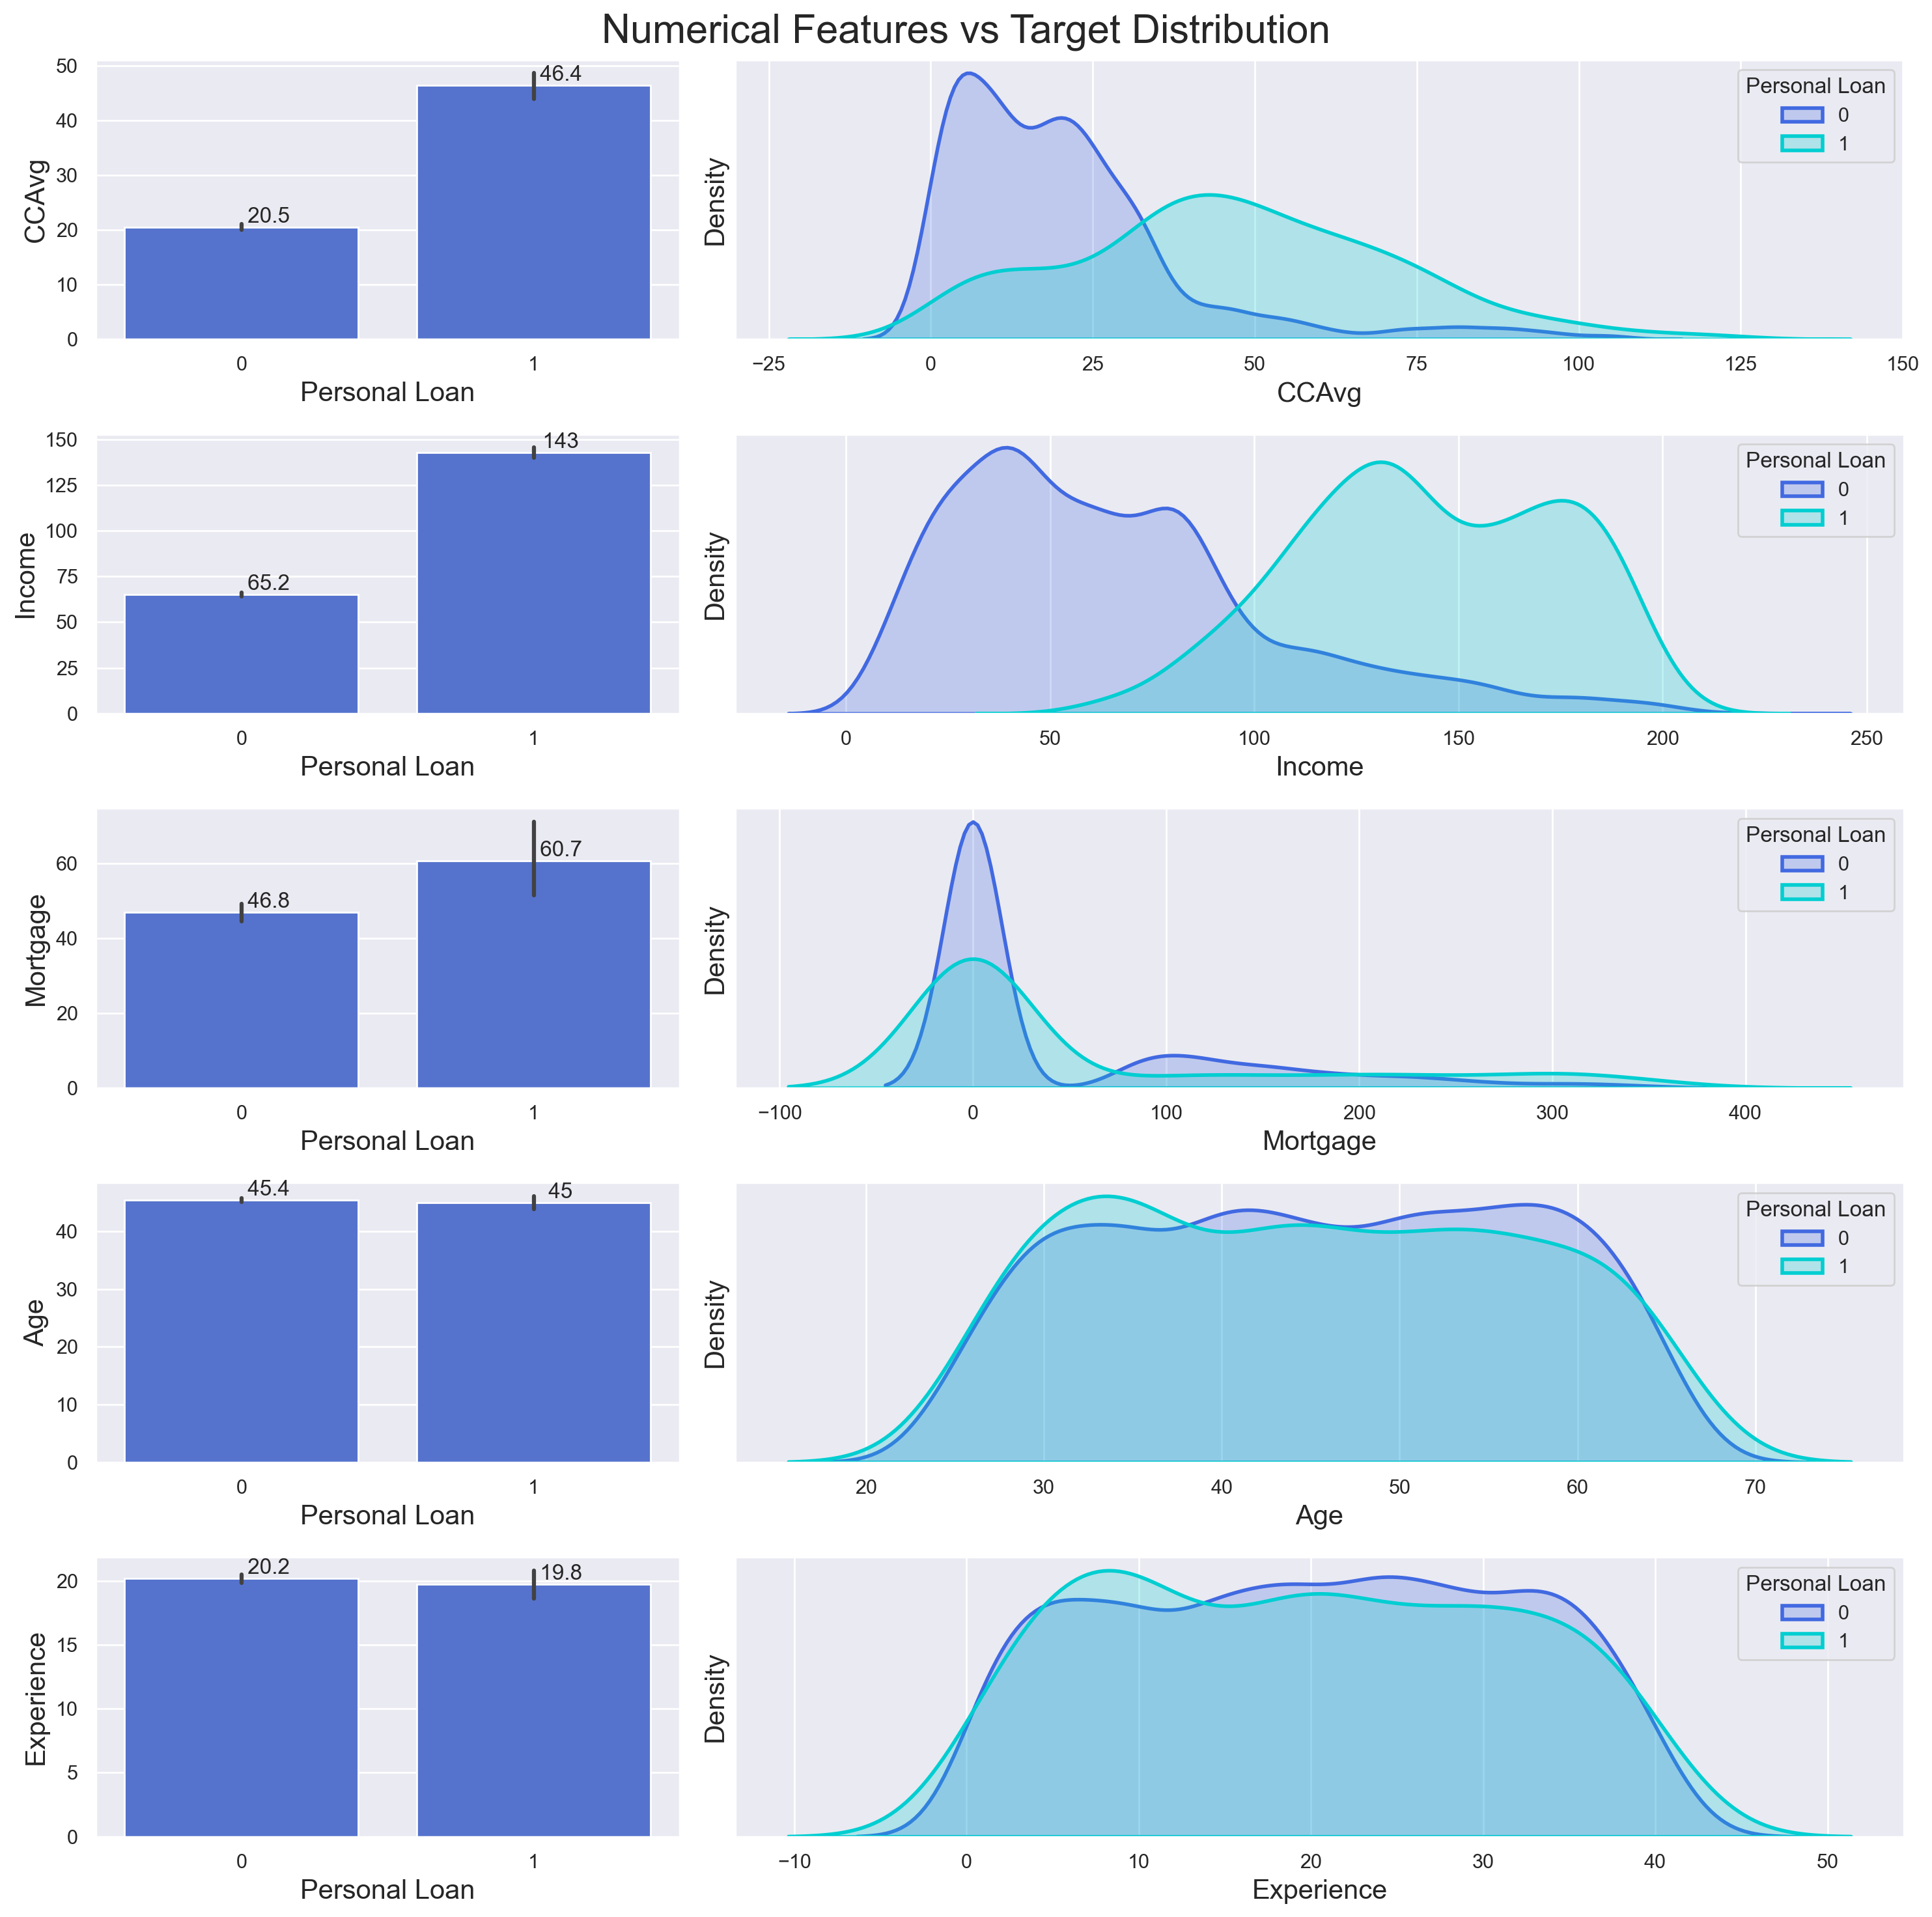

In [19]:
sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(5, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Personal Loan', loc='upper right')
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

Experience(근무 경력)이 개인 대출 구매에 미치는 영향은 나이와 유사합니다. 근무 경력의 분포는 나이 분포와 매우 비슷하며, 이는 근무 경력이 나이와 강하게 상관되어 있기 때문입니다. 따라서, Experience는 Age에 비해 추가적인 정보를 제공하지 않으므로, 분석에서 제외했습니다.

In [20]:
df.drop('Experience', axis=1, inplace=True)

# Train Test Split

In [21]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'] 

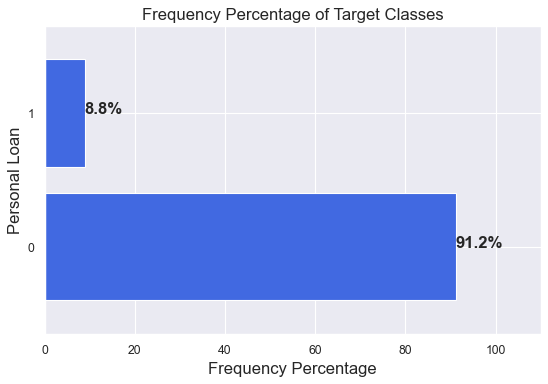

In [22]:
plt.figure(dpi=80)

# Plot
df['Personal Loan'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

labels = df['Personal Loan'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Personal Loan', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

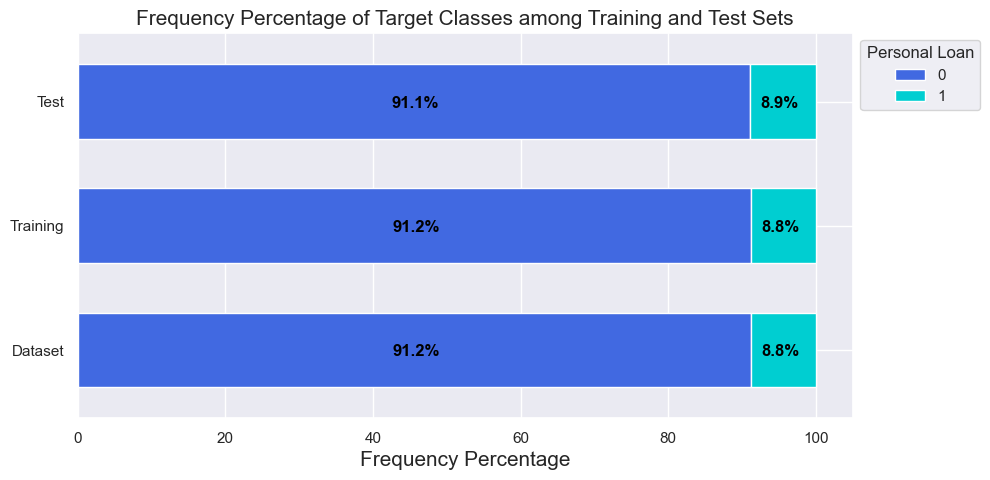

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Training','Test']
df_perc = df_perc.T

# Plot
df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)
for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Personal Loan', loc=(1.01,0.8))
plt.xlabel('Frequency Percentage', fontsize=15)
plt.title('Frequency Percentage of Target Classes among Training and Test Sets', fontsize=15)
plt.show()            

In [24]:
#성능 평가하는 점수방법
def f1_metric(model, X_train, y_train):
    return f1_score(y_train, model.predict(X_train), average='binary')

In [25]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    importances = []
    # 모델 클론
    model_clone = clone(model)
    model_clone.random_state = random_state
    # 학습
    model_clone.fit(X_train, y_train)
    # StratifiedKFold 이용한 교차검증
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # 교차검증을 통한 벤치마크 점수
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring=f1_metric).mean()

    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Drop column model의 점수
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring=f1_metric).mean()
        importances.append(benchmark_score - drop_column_score)
        
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df

def drop_column_importance_plot(model, X_train, y_train):
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    df_drop_column.columns = ['Feature', 'Feature Importance']
    
    # Plot
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='royalblue')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

# Complement NB Model Building

In [26]:
# 연속형 특징을 이산화하기 위한 최적의 n_bins와 strategy를 찾아주는 함수

def discretization_report(df, clf):
    # 이산화해야 하는 연속형 특성들
    cols_to_discretize = ['Age', 'Income', 'CCAvg', 'Mortgage']
 
    X = df[cols_to_discretize]
    y = df['Personal Loan']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    # GridSearch 파라미터
    param_grid = {'discretizer__strategy': ['uniform', 'quantile', 'kmeans'],
                  'discretizer__n_bins': np.arange(2,11)}

    # KBinsDiscretizer, OneHotEncoder
    discretizer = KBinsDiscretizer(encode='ordinal')
    onehot = OneHotEncoder(handle_unknown='ignore', drop='first')

    pipeline = Pipeline([('discretizer', discretizer), ('onehot', onehot), ('clf', clf)])

    # StratifiedKFold를 이용한 교차검증 (모든 폴드에서 클래스 분포가 동일하도록)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1')
    
    grid_search.fit(X_train, y_train)

    print("Best discretization parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    
    return grid_search.best_params_['discretizer__n_bins'], grid_search.best_params_['discretizer__strategy']

In [27]:
# bin의 너비가 너무 작아지는 경우, 오류가 발생하니 이 경고를 무시해주는 함수
warnings.simplefilter(action='ignore')

# CNB
cnb = ComplementNB()

# discretization_report
n_bins, strategy = discretization_report(df, cnb)

  File "c:\Users\dongk\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\dongk\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dongk\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\dongk\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Best discretization parameters: {'discretizer__n_bins': 6, 'discretizer__strategy': 'quantile'}
Best score: 0.5354708442834474


In [28]:
# 이 함수는 최적의 n_bins와 strategy 값을 고려하여 특징 이산화를 수행한 후, 지정된 범주형 특징에 대해 더미 인코딩을 수행합니다.

def nb_feature_encoding(df, n_bins, strategy, cols_to_encode):
    # 이산화해야 하는 연속형 특성들
    cols_to_discretize = ['Age', 'Income', 'CCAvg', 'Mortgage']
 
    X = df.drop('Personal Loan', axis=1)
    y = df['Personal Loan'] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    # 연속형 특성들을 이산화하기
    discretizer = KBinsDiscretizer(n_bins=n_bins, strategy=strategy, encode='ordinal')
    X_train[cols_to_discretize] = discretizer.fit_transform(X_train[cols_to_discretize])
    X_test[cols_to_discretize] = discretizer.transform(X_test[cols_to_discretize])

    # 원핫인코딩
    X_train = pd.get_dummies(X_train, columns=cols_to_encode, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=cols_to_encode, drop_first=True)
    
    # 테스트 세트의 열을 훈련 세트와 정렬
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    
    return X_train, X_test

In [29]:
# 모든 non-binary 특징을 원-핫 인코딩 대상으로 선택
cols_to_encode = ['Age', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education']

# nb_feature_encoding
X_train, X_test = nb_feature_encoding(df, n_bins, strategy, cols_to_encode)

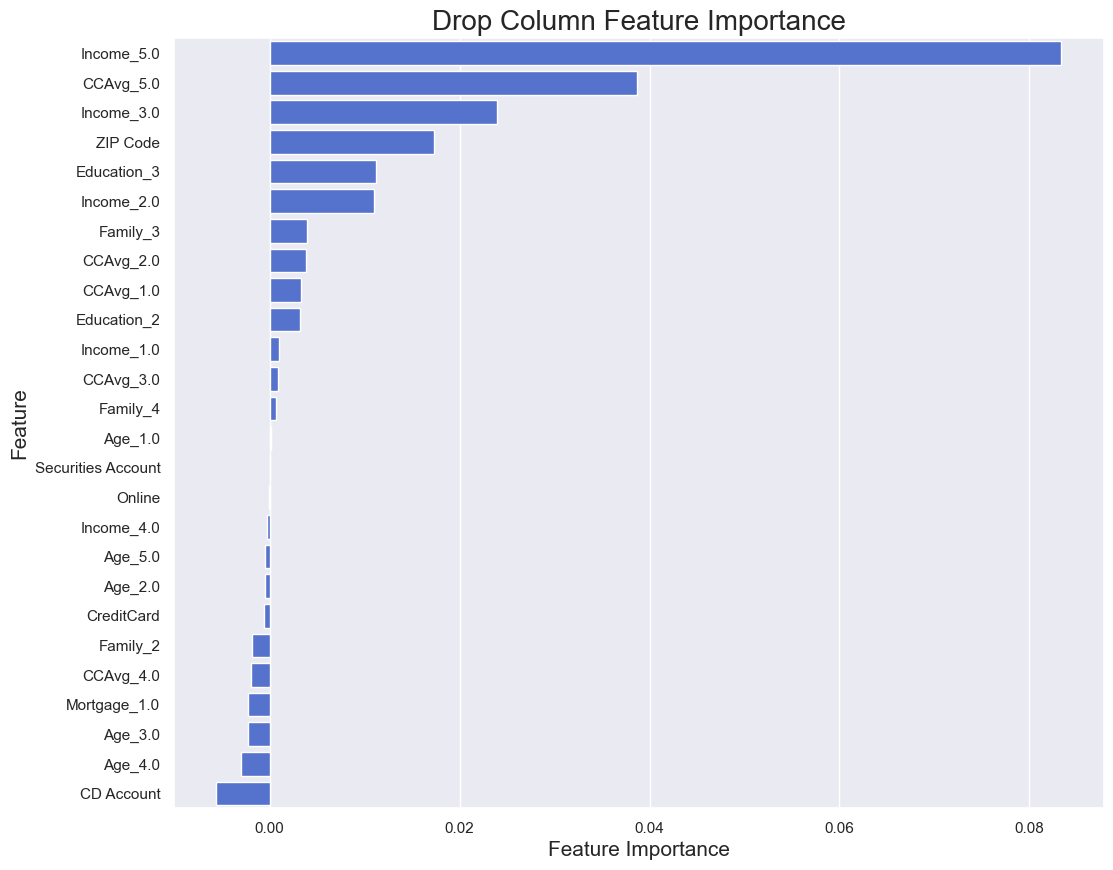

In [30]:
# CNB
cnb = ComplementNB()

# drop_column으로 특성 중요도 출력
drop_column_importance_plot(cnb, X_train, y_train)

In [31]:
feature_importances = drop_column_importance(cnb, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [32]:
cnb = ComplementNB()
cnb.fit(X_train, y_train)

ComplementNB()

In [33]:
# 모델의 성능을 평가하기 위한 함수
def metrics_calculator(clf, X_test, y_test, model_name):
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [34]:
# 모델의 성능에 대한 분류 보고서, 혼동 행렬, ROC 곡선을 포함한 종합적인 보고서를 만들어주는 함수
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    sns.set(font_scale=1.2)
    
    # 훈련 세트에 대한 분류 보고서
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # 테스트 세트에 대한 분류 보고서
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # 테스트 세트에 대한 혼동 행렬
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # 테스트 데이터에 대한 ROC 곡선과 AUC 점수
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # 양성 라벨로 지정된 클래스에 대한 결과
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3569
           1       0.41      0.95      0.57       346

    accuracy                           0.88      3915
   macro avg       0.70      0.91      0.75      3915
weighted avg       0.94      0.88      0.90      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       892
           1       0.38      0.94      0.54        87

    accuracy                           0.86       979
   macro avg       0.69      0.90      0.73       979
weighted avg       0.94      0.86      0.88       979



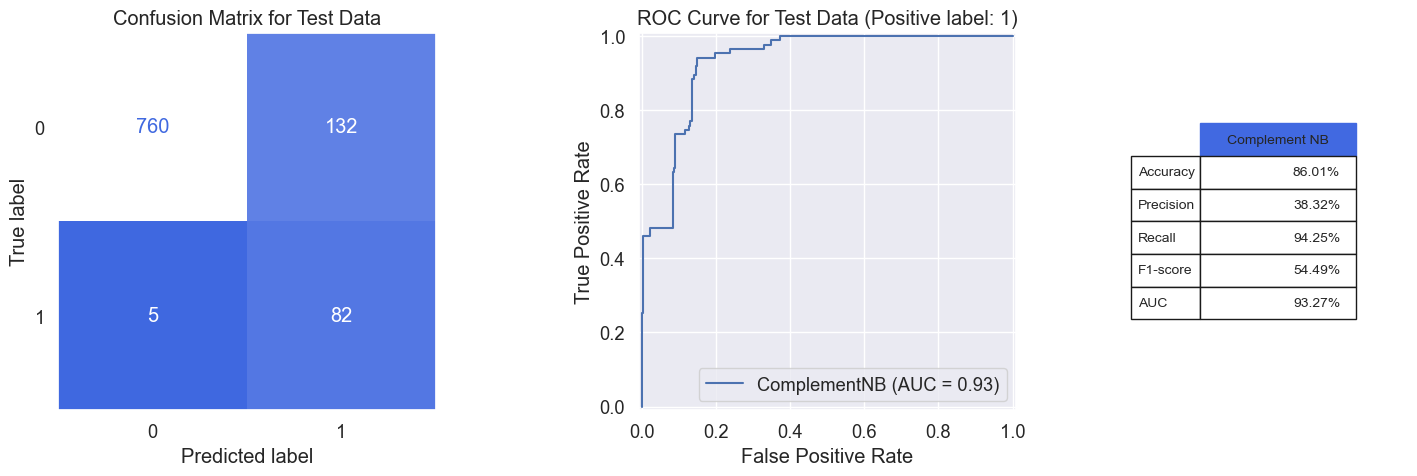

In [35]:
model_evaluation(cnb, X_train, X_test, y_train, y_test, 'Complement NB')

In [36]:
# Complement Naive Bayes 분류기의 최종 성능을 저장
cnb_result = metrics_calculator(cnb, X_test, y_test, 'Complement Naive Bayes')

# Bernoulli NB Model Building

In [37]:
# BNB
bnb = BernoulliNB()

# discretization_report
n_bins, strategy = discretization_report(df, bnb)

Best discretization parameters: {'discretizer__n_bins': 9, 'discretizer__strategy': 'uniform'}
Best score: 0.5184448691429347


In [38]:
df_bnb = df.copy()
df_bnb.drop('ZIP Code', axis=1, inplace=True)

In [39]:
# 모든 non-binary 특징을 원-핫 인코딩 대상으로 선택
cols_to_encode = ['Age', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education']

# nb_feature_encoding
X_train, X_test = nb_feature_encoding(df_bnb, n_bins, strategy, cols_to_encode)

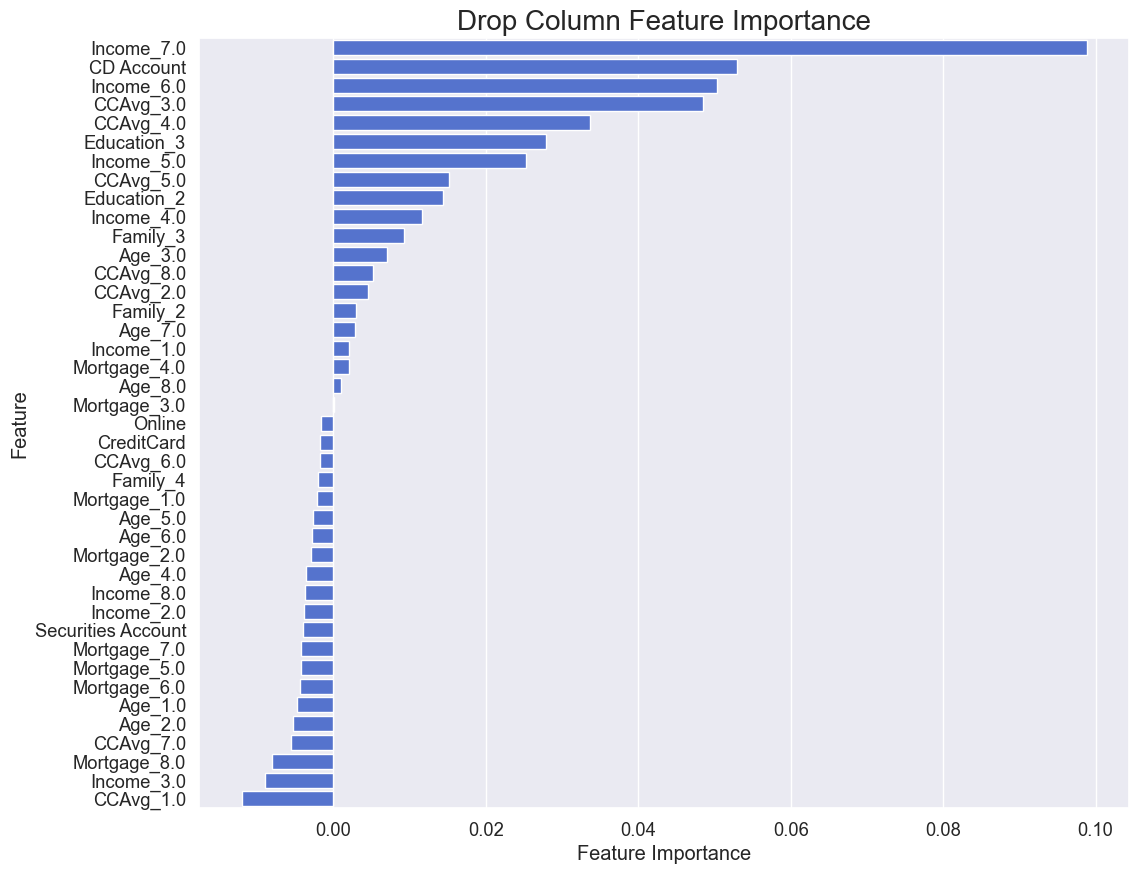

In [40]:
# BNB
bnb = BernoulliNB()

# drop_column으로 특성 중요도 출력
drop_column_importance_plot(bnb, X_train, y_train)

In [41]:
feature_importances = drop_column_importance(bnb, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [42]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3569
           1       0.73      0.55      0.63       346

    accuracy                           0.94      3915
   macro avg       0.85      0.77      0.80      3915
weighted avg       0.94      0.94      0.94      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       892
           1       0.72      0.51      0.59        87

    accuracy                           0.94       979
   macro avg       0.84      0.74      0.78       979
weighted avg       0.93      0.94      0.93       979



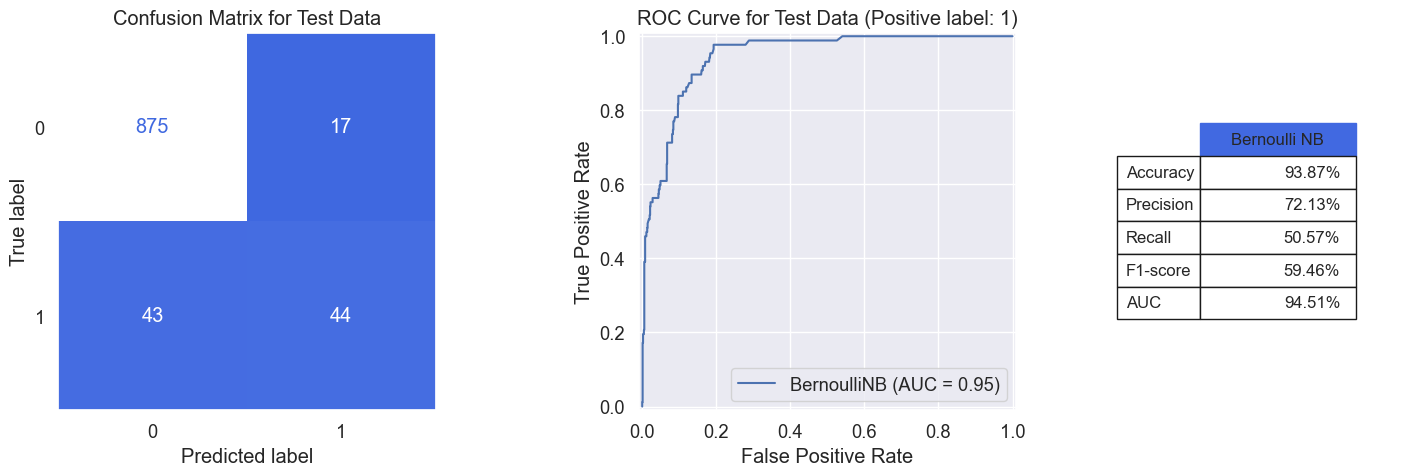

In [43]:
model_evaluation(bnb, X_train, X_test, y_train, y_test, 'Bernoulli NB')

In [44]:
# Bernoulli Naive Bayes 분류기의 최종 성능을 저장
bnb_result = metrics_calculator(bnb, X_test, y_test, 'Bernoulli Naive Bayes')

# Logistic Regression

In [45]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [46]:
# 훈련 데이터와 테스트 데이터를 동일한 스케일러를 사용하여 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 훈련 세트와 테스트 세트를 NumPy 배열에서 Pandas 데이터프레임으로 변환
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [47]:
# 클래스에 할당된 가중치
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,20)]

# 하이퍼파라미터 그리드
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'], 
               'penalty':['none'], 
               'class_weight':class_weights}, 
              
              {'solver':['lbfgs', 'newton-cg', 'sag'], 
               'penalty':['l2'], 
               'C': np.logspace(-5, 5, 10), 
               'class_weight':class_weights},
              
              {'solver':['liblinear', 'saga'], 
               'penalty': ['l1', 'l2'], 
               'C': np.logspace(-5, 5, 10), 
               'class_weight':class_weights},
              
              {'solver':['saga'], 
               'penalty':['elasticnet'], 
               'C': np.logspace(-5, 5, 10),
               'l1_ratio': np.arange(0,1.1,0.1), 
               'class_weight':class_weights}]    

In [48]:
# 이 함수는 지정된 하이퍼파라미터 그리드를 탐색하여 분류기의 하이퍼파라미터를 최적화
# GridSearchCV와 StratifiedKFold을 사용해 다양한 하이퍼파라미터 조합을 평가하고, F1-score가 가장 높은 조합을 선택

def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    # StratifiedKFold를 이용한 교차검증 (모든 폴드에서 클래스 분포가 동일하도록)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # GridSearchCV
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=f1_metric, n_jobs=1)

    # Fit
    clf_grid.fit(X_train, y_train)

    # 최적의 하이퍼 파라미터 출력
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    return clf_grid.best_estimator_

In [49]:
# 로지스틱 회귀
logreg = LogisticRegression(max_iter=1000)

# 최적의 하이퍼 파라미터 조합
logreg_opt = tune_clf_hyperparameters(logreg, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 3.593813663804626, 'class_weight': {0: 0.4474736842105263, 1: 0.5525263157894738}, 'l1_ratio': 0.2, 'penalty': 'elasticnet', 'solver': 'saga'}


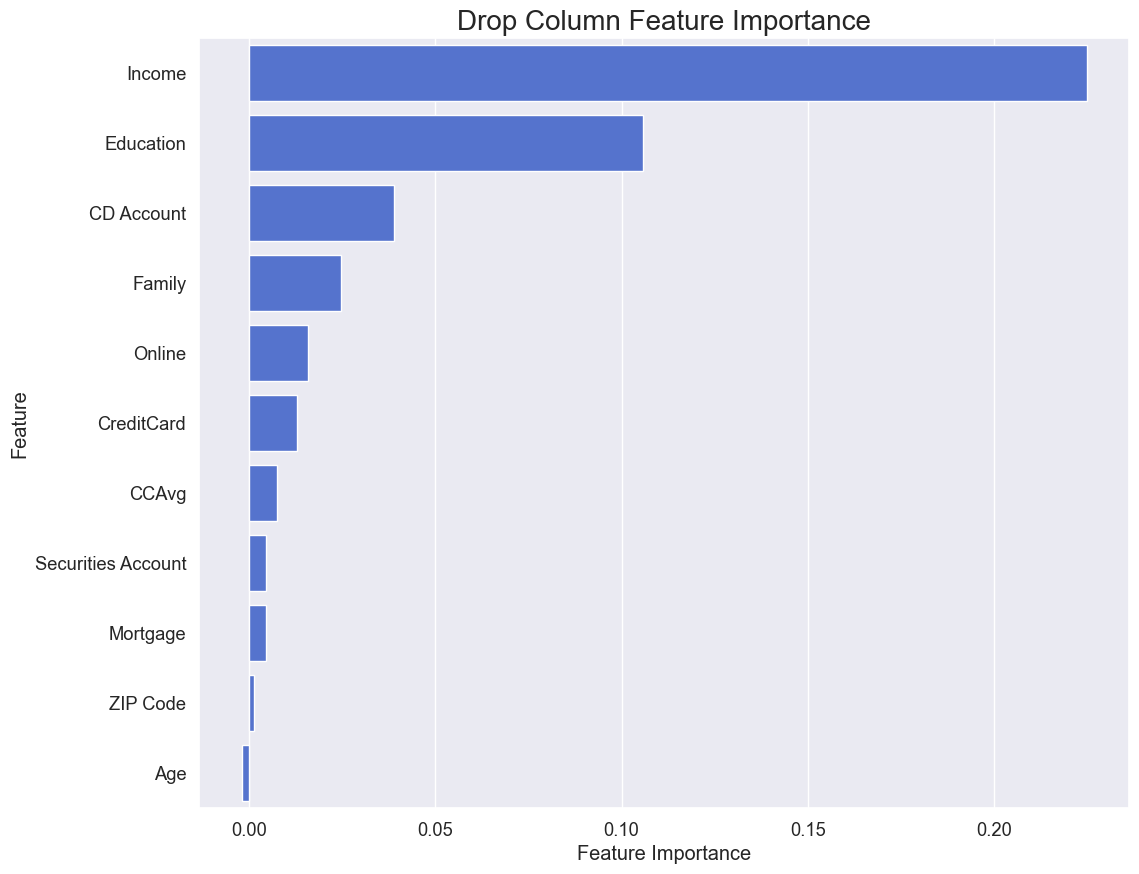

In [50]:
drop_column_importance_plot(logreg_opt, X_train, y_train)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3569
           1       0.81      0.65      0.72       346

    accuracy                           0.96      3915
   macro avg       0.89      0.82      0.85      3915
weighted avg       0.95      0.96      0.95      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       892
           1       0.72      0.67      0.69        87

    accuracy                           0.95       979
   macro avg       0.85      0.82      0.83       979
weighted avg       0.95      0.95      0.95       979



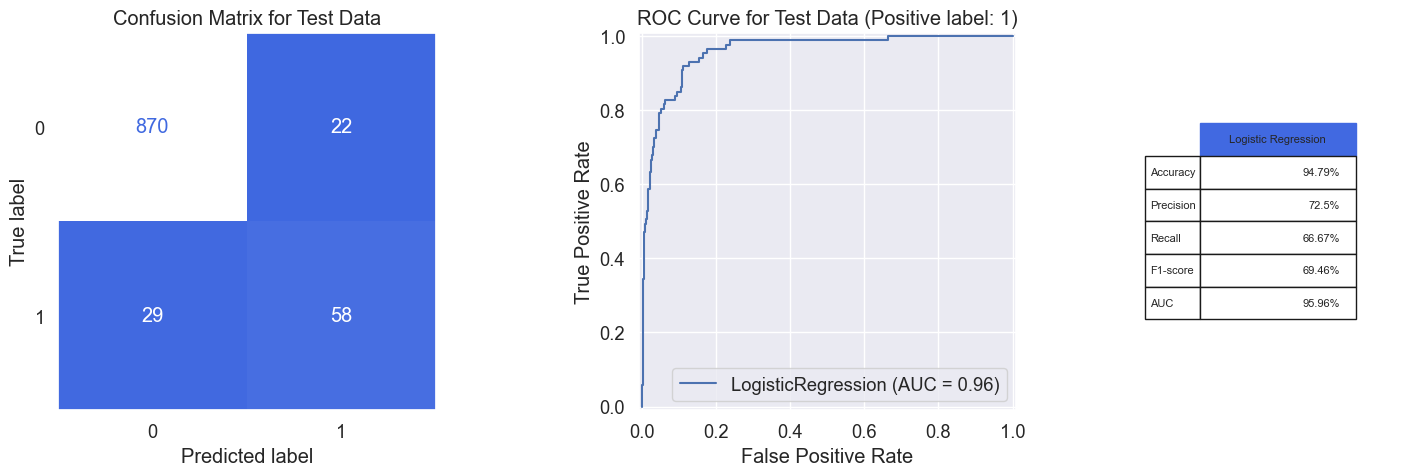

In [51]:
model_evaluation(logreg_opt, X_train, X_test, y_train, y_test, 'Logistic Regression')

In [52]:
# 로지스틱 회귀 분류기의 최종 성능을 저장
logreg_result = metrics_calculator(logreg_opt, X_test, y_test, 'Logistic Regression')

# Primary XGBoost
초기 하이퍼 파라미터를 이용한 XGBoost

In [53]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [54]:
# XGBoost 분류기의 초기 하이퍼파라미터
xgb_opt = XGBClassifier(max_depth=5,
                        learning_rate=0.3,
                        n_estimators=200,
                        min_child_weight=1,
                        scale_pos_weight=1.5,
                        colsample_bytree=0.8,
                        gamma=0.1,
                        booster='gbtree',
                        objective='binary:logistic',
                        eval_metric='error', 
                        random_state=0)

xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

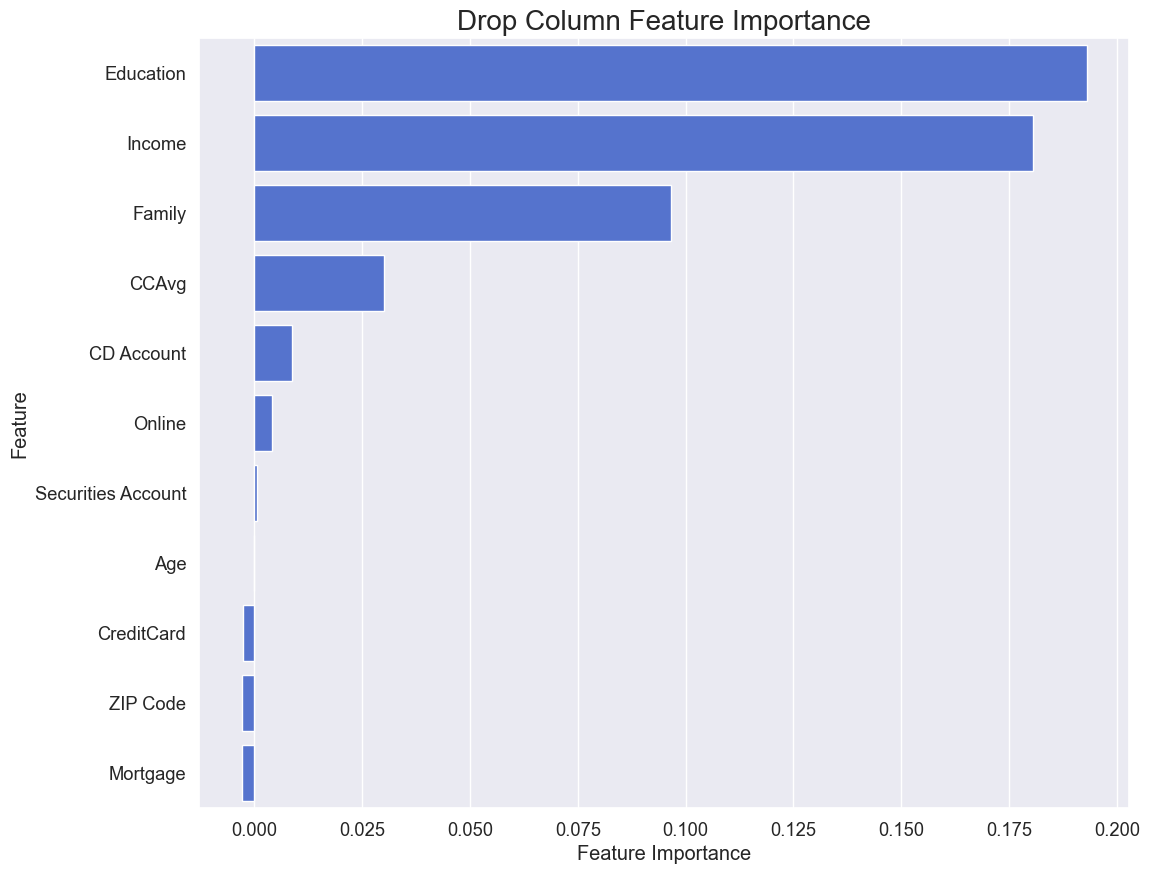

In [55]:
drop_column_importance_plot(xgb_opt, X_train, y_train)

In [56]:
# 중요한 특성 찾기
feature_importances = drop_column_importance(xgb_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.002]['feature'] # Threshold value of 0.002

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [57]:
# 관련 없는 특성들을 모두 제거한 후, 다시 초기 하이퍼파라미터를 이용한 XGBoost 실행하기
xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.3,
                    n_estimators=200,
                    min_child_weight=1,
                    scale_pos_weight=1.5,
                    colsample_bytree=0.8,
                    gamma=0.1,
                    booster='gbtree',
                    objective='binary:logistic',
                    eval_metric='error', 
                    random_state=0)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.92      0.94        87

    accuracy                           0.99       979
   macro avg       0.97      0.96      0.96       979
weighted avg       0.99      0.99      0.99       979



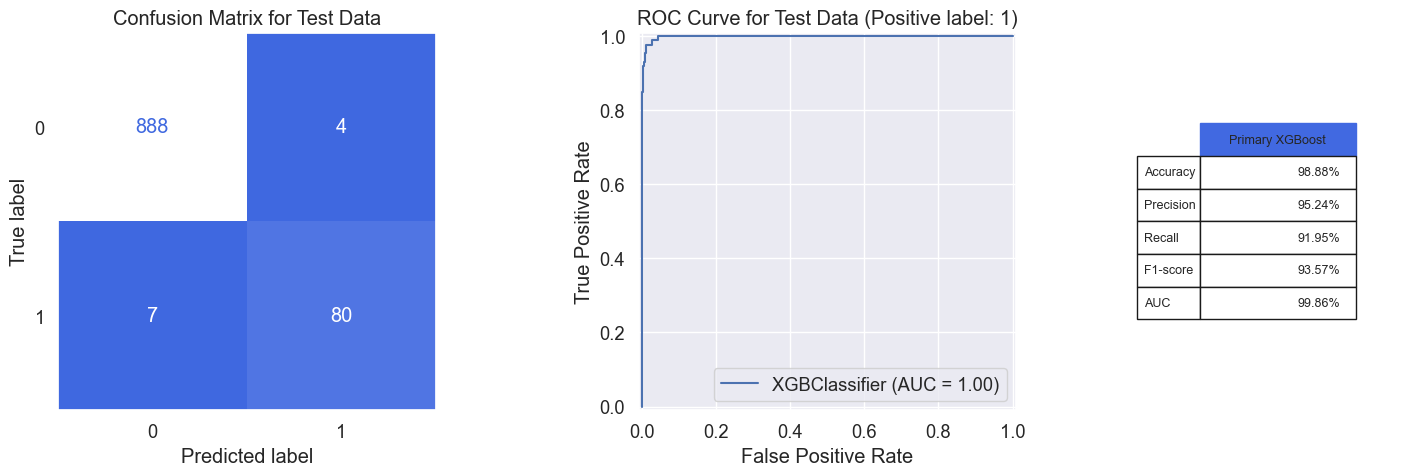

In [58]:
model_evaluation(xgb, X_train, X_test, y_train, y_test, 'Primary XGBoost')

# Final XGBoost
하이퍼 파라미터를 조정한 XGBoost

In [59]:
# 하이퍼 파라미터를 조정한 XGBoost
xgb_final = XGBClassifier(max_depth=4,
                          learning_rate=0.3,
                          n_estimators=200,
                          min_child_weight=1,
                          scale_pos_weight=1.5,
                          colsample_bytree=0.8,
                          gamma=0.1,
                          booster='gbtree',
                          objective='binary:logistic',
                          eval_metric='error', 
                          random_state=0)

xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.92      0.94        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



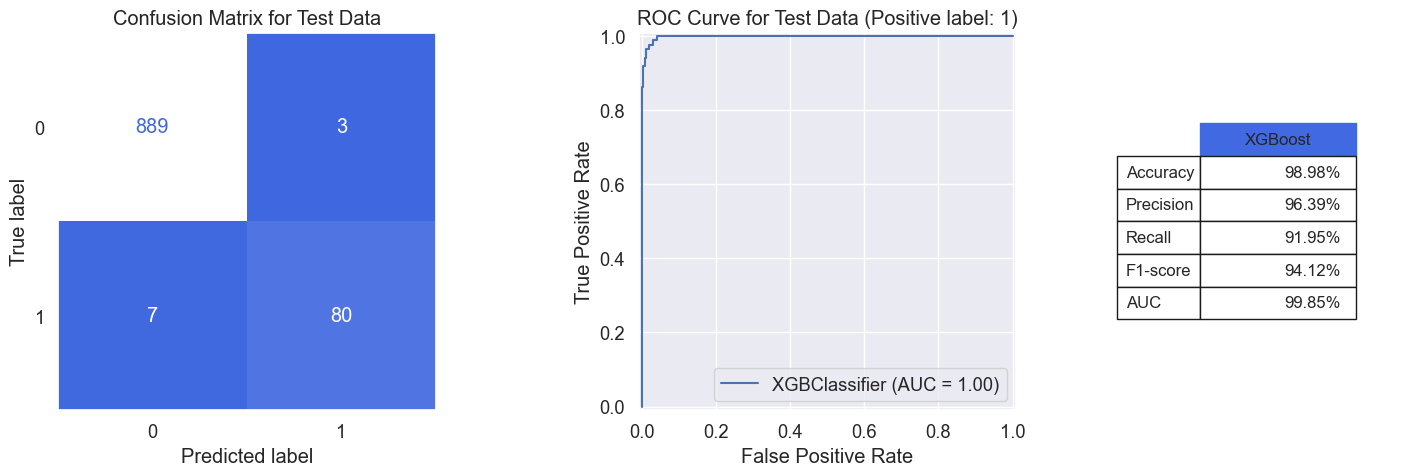

In [60]:
model_evaluation(xgb_final, X_train, X_test, y_train, y_test, 'XGBoost')

In [61]:
# XGBoost의 최종 성능을 저장
xgb_result = metrics_calculator(xgb_final, X_test, y_test, 'XGBoost')

# Conclusion

In [62]:
# 이전 분류기들의 성능 결과를 하나의 데이터프레임으로 결합
results = pd.concat([cnb_result, bnb_result, logreg_result, xgb_result], axis=1).T

# 데이터프레임을 F1-score 값을 기준으로 내림차순으로 정렬
results.sort_values(by='F1-score', ascending=False, inplace=True)

results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

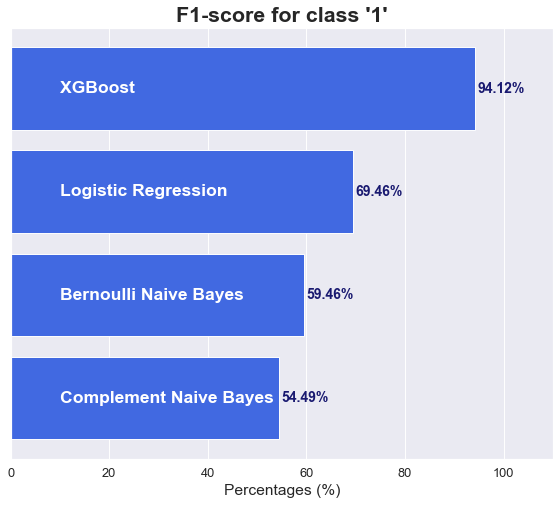

In [63]:
results.sort_values(by='F1-score', ascending=True, inplace=True)
f1_scores = results['F1-score'].str.strip('%').astype(float)

fig, ax = plt.subplots(figsize=(10, 8), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='midnightblue')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

ax.set_yticks([])

ax.set_xlim([0,110])

plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [65]:
print(df.columns)

Index(['Age', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage',
       'Personal Loan', 'Securities Account', 'CD Account', 'Online',
       'CreditCard'],
      dtype='object')


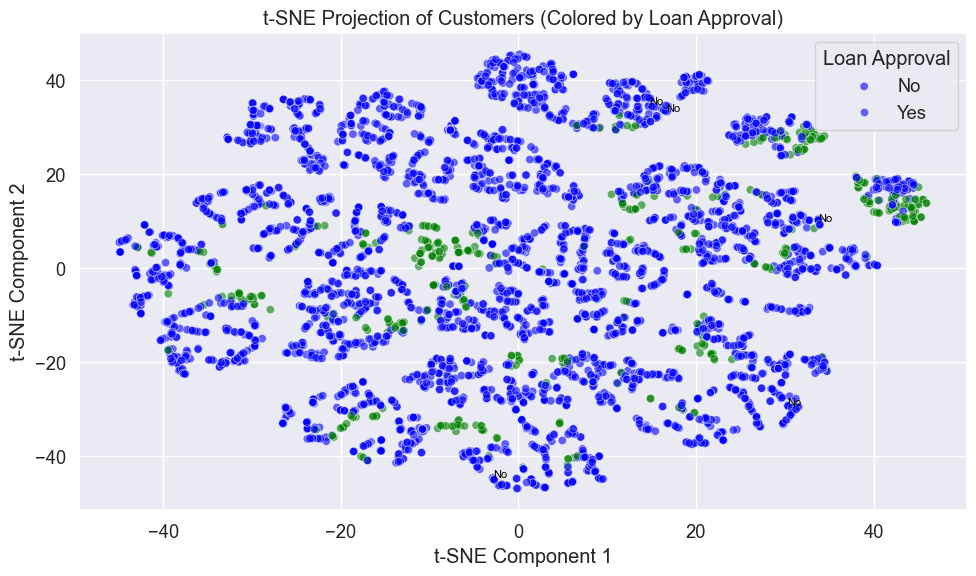

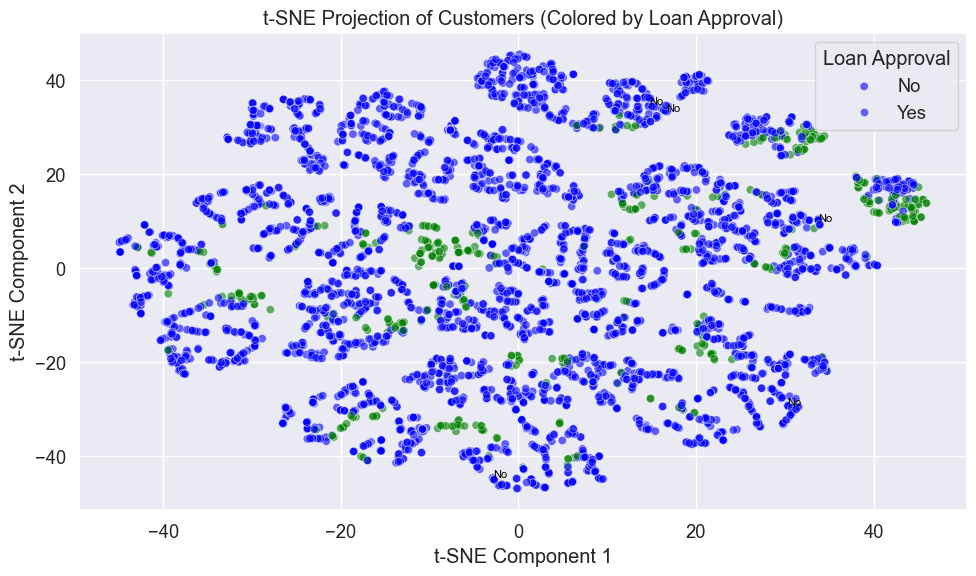

In [69]:
# === t-SNE Visualization of Customer Features by Loan Approval ===
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Drop only ZIP Code and label column, since there's no "ID"
X = df.drop(columns=["ZIP Code", "Personal Loan"])
y = df["Personal Loan"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot the result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette=["blue", "green"], alpha=0.6)

# Annotate a few example points
for i in range(5):
    label = "Yes" if y.iloc[i] == 1 else "No"
    plt.text(X_tsne[i, 0], X_tsne[i, 1], f"{label}", fontsize=8, color='black')

plt.title("t-SNE Projection of Customers (Colored by Loan Approval)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Loan Approval", labels=["No", "Yes"])
plt.tight_layout()
import os
os.makedirs("results", exist_ok=True)
plt.savefig("results/tsne_loan_projection.png")
plt.show()

